Original code from:
https://github.com/je-suis-tm/quant-trading/blob/master/Parabolic%20SAR%20backtest.py

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
warnings.simplefilter("ignore")


def parabolic_sar(new):
    
    #this is common accelerating factors for forex and commodity
    #for equity, af for each step could be set to 0.01
    initial_af=0.02
    step_af=0.02
    end_af=0.2
    
    
    new['trend']=0
    new['sar']=0.0
    new['real sar']=0.0
    new['ep']=0.0
    new['af']=0.0

    #initial values for recursive calculation
    new['trend'][1]=1 if new['Close'][1]>new['Close'][0] else -1
    new['sar'][1]=new['High'][0] if new['trend'][1]>0 else new['Low'][0]
    new.at[1,'real sar']=new['sar'][1]
    new['ep'][1]=new['High'][1] if new['trend'][1]>0 else new['Low'][1]
    new['af'][1]=initial_af

    #calculation
    for i in range(2,len(new)):
        
        temp=new['sar'][i-1]+new['af'][i-1]*(new['ep'][i-1]-new['sar'][i-1])
        if new['trend'][i-1]<0:
            new.at[i,'sar']=max(temp,new['High'][i-1],new['High'][i-2])
            temp=1 if new['sar'][i]<new['High'][i] else new['trend'][i-1]-1
        else:
            new.at[i,'sar']=min(temp,new['Low'][i-1],new['Low'][i-2])
            temp=-1 if new['sar'][i]>new['Low'][i] else new['trend'][i-1]+1
        new.at[i,'trend']=temp
    
        
        if new['trend'][i]<0:
            temp=min(new['Low'][i],new['ep'][i-1]) if new['trend'][i]!=-1 else new['Low'][i]
        else:
            temp=max(new['High'][i],new['ep'][i-1]) if new['trend'][i]!=1 else new['High'][i]
        new.at[i,'ep']=temp
    
    
        if np.abs(new['trend'][i])==1:
            temp=new['ep'][i-1]
            new.at[i,'af']=initial_af
        else:
            temp=new['sar'][i]
            if new['ep'][i]==new['ep'][i-1]:
                new.at[i,'af']=new['af'][i-1]
            else:
                new.at[i,'af']=min(end_af,new['af'][i-1]+step_af)
        new.at[i,'real sar']=temp
       
        
    return new

def signal_generation(df,method):
    
        new=method(df)

        new['positions'],new['signals']=0,0
        new['positions']=np.where(new['real sar']<new['Close'],1,0)
        new['signals']=new['positions'].diff()
        
        return new



def plot(new,ticker,og):
    
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(111)

    og["MA_50"] = og['Close'].rolling(window=50).mean()
    og["MA_200"] = og['Close'].rolling(window=200).mean()
    og = og[['MA_50', 'MA_200']]

    final_df = pd.concat([new, og], axis=1)
    final_df.dropna(inplace=True)
        
    final_df['Close'].plot(lw=3,label='%s'%ticker)
    final_df['real sar'].plot(linestyle=':',label='Parabolic SAR',color='k')
    final_df['MA_50'].plot(linestyle='-',label='MA_50',color='orange', linewidth=2)
    final_df['MA_200'].plot(linestyle='-',label='MA_200',color='black', linewidth=3)
    ax.plot(final_df.loc[final_df['signals']==1].index,final_df['Close'][final_df['signals']==1],marker='^',color='g',label='LONG',lw=0,markersize=10)
    ax.plot(final_df.loc[final_df['signals']==-1].index,final_df['Close'][final_df['signals']==-1],marker='v',color='r',label='SHORT',lw=0,markersize=10)
    
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.%Y'))
    fig.autofmt_xdate()
    
    plt.legend()
    plt.grid(True)
    plt.title('Parabolic SAR')
    plt.ylabel('price')
    plt.show()


[*********************100%***********************]  1 of 1 completed


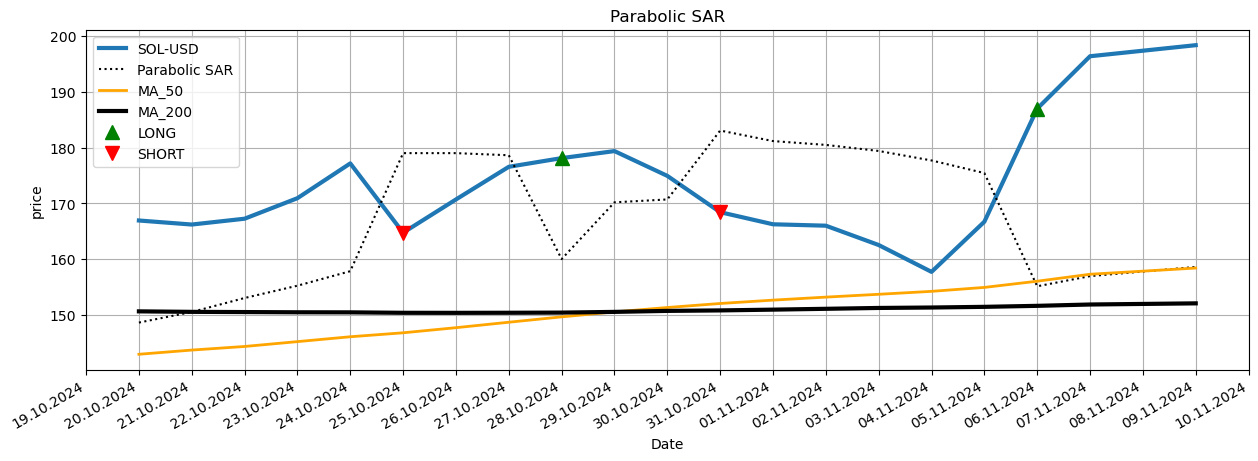

In [61]:
stdate=('2020-01-01')
eddate=('2025-01-01')
ticker=('SOL-USD')



df=yf.download(ticker,start=stdate,end=eddate)

del df['Adj Close']
del df['Volume']

df.reset_index(inplace=True)

new=signal_generation(df,parabolic_sar)


new.set_index(new['Date'],inplace=True)
og = new.copy()

#shorten our plotting horizon and plot
trade_start = '2024-10-20'
trade_end = '2025-01-01'
new = new[(new.index >= trade_start) &(new.index <= trade_end) ]
plot(new,ticker,og) 